In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import logging # Allows us to check the progress of our LDA model
import re # Regex

# For Topic Modelling
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Visualising Topic Model
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import seaborn as sns

# Word cloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Enable in-notebook visualizations
%matplotlib inline
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

df=pd.read_excel('data/redditfilter.xlsx', index_col = 0)

/Users/jacqualync/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def my_tokenizer(s):
    tokens = nltk.tokenize.word_tokenize(str(s))
    return tokens

df['title'] = df.tweets.apply(my_tokenizer)
#df.to_excel('data/redditcorpus.xlsx', index=True)

# Generating dictionary and corpus

In [4]:
docs=df.title
dictionary = gensim.corpora.Dictionary(docs) 
# Filter out extreme values
dictionary.filter_extremes(no_below=0.005*dictionary.num_docs, no_above=1) 
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 859
Number of documents: 2109


# Finding optimal number of topics

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(coherencemodel.get_coherence())
    return model_list, coherence_values

0.47552010137140494
0.5875762189333246
0.5373829480040516
0.5143934582754753
0.5064542425789211


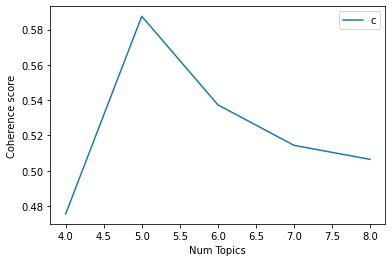

In [7]:
# Parameters
limit=9; start=4; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, 
                                                        corpus=corpus, texts=docs, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6,
                       passes = 100, random_state = 100)

lda_model.save('data/ldamodel/ldareddit.model') 

# Visualise topic-word distribution¶

In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.172666 -0.165588       1        1  29.699692
0     -0.058563  0.226226       2        1  29.364633
3      0.080552  0.093820       3        1  15.893419
5      0.150299 -0.158539       4        1  10.948036
2      0.029991  0.147284       5        1   9.164811
4     -0.374945 -0.143203       6        1   4.929409, topic_info=                Term         Freq        Total Category  logprob  loglift
26          wildfire  1273.000000  1273.000000  Default  30.0000  30.0000
58              fire  1011.000000  1011.000000  Default  29.0000  29.0000
4         california  1265.000000  1265.000000  Default  28.0000  28.0000
104             post   219.000000   219.000000  Default  27.0000  27.0000
532  imagesofnetwork   110.000000   110.000000  Default  26.0000  26.0000
..               ...          ...          ...      ...      ...      ...
106             read    23.955117    92.183623   Topic6  -4.4146   1.6624
138             line    20.351039    68.685797   Topic6  -4.5777   1.7935
220           change    28.253635   182.672798   Topic6  -4.2496   1.1435
4         california    27.836339  1265.505050   Topic6  -4.2645  -0.8069
66              hope    13.566670    34.361099   Topic6  -4.9832   2.0806

[350 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
379       2  0.202495          *****
379       4  0.787482          *****
380       4  0.969759      **fire**^
699       4  0.911299      **home**^
663       4  0.942203  **wildfire**^
...     ...       ...            ...
171       1  0.127850           year
171       2  0.140963           year
171       3  0.331098           year
171       5  0.399940           year
492       3  0.986939           zone

[516 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 6, 3, 5])

# Using word cloud to infer our topics

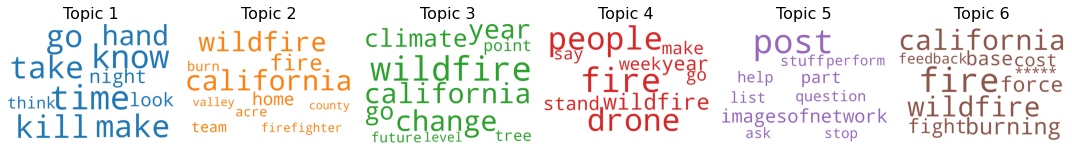

In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 6, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

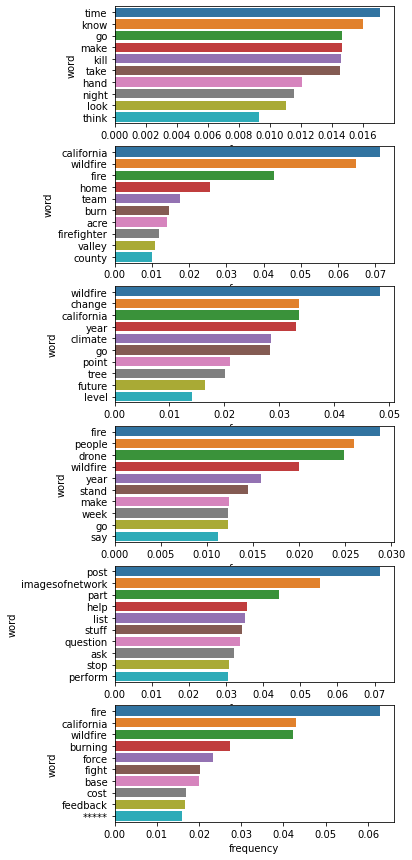

In [12]:
import seaborn as sns
f=plt.figure(figsize=(5,15))
    
for i in range(6):
    topic = pd.DataFrame(topics[i][1])
    topic.columns=['word','frequency']
    f.add_subplot(6,1,i+1)
    sns.barplot(data=topic,x="frequency",y="word")

# Generating dominant topic for each document

In [13]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)
df_topic_keywords = pd.concat([df_topic_keywords, df.time], axis=1)
# df_topic_keywords.columns = ['Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'title', 'date']
df_topic_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,title,time
0,1.0,0.9290,"california, wildfire, fire, home, team, burn, ...","[fight, reading, sound, spoon, liar.., liar, t...",2016-06-23
1,4.0,0.4169,"post, imagesofnetwork, part, help, list, stuff...","[expert, seem, text, query, look, nail, beat, ...",2016-06-03
2,0.0,0.3809,"time, know, go, make, kill, take, hand, night,...","[_______, title, genre, logline, thanks, time,...",2016-06-04
3,3.0,0.3787,"fire, people, drone, wildfire, year, stand, ma...","[write, synopsis, go, read, synopsis, query, l...",2016-06-04
4,2.0,0.7902,"wildfire, change, california, year, climate, g...","[read, post, guideline, expect, feedback, requ...",2016-06-03
...,...,...,...,...,...
2104,1.0,0.9919,"california, wildfire, fire, home, team, burn, ...","[building, threaten, california, wildfire]",2016-09-27
2105,0.0,0.9991,"time, know, go, make, kill, take, hand, night,...","[photo, california, wildfire, endangers, canna...",2016-09-28
2106,2.0,0.9871,"wildfire, change, california, year, climate, g...","[date, california, weather, history, september...",2016-09-28
2107,2.0,0.9665,"wildfire, change, california, year, climate, g...","[california, mountain, home, threaten, destruc...",2016-09-28


# Plotting topic over time

In [14]:
topics = []
for i in range(6):
    wp = lda_model.show_topic(i)
    topic_keywords = ", ".join([word for word, prop in wp])
    topics.append(topic_keywords)
topics

['time, know, go, make, kill, take, hand, night, look, think',
 'california, wildfire, fire, home, team, burn, acre, firefighter, valley, county',
 'wildfire, change, california, year, climate, go, point, tree, future, level',
 'fire, people, drone, wildfire, year, stand, make, week, go, say',
 'post, imagesofnetwork, part, help, list, stuff, question, ask, stop, perform',
 'fire, california, wildfire, burning, force, fight, base, cost, feedback, *****']

In [15]:
topic_time = pd.DataFrame()
for topic in topics:
    topici = df_topic_keywords[df_topic_keywords.Topic_Keywords==topic].groupby(df_topic_keywords.time).count().title
    topici.columns = [topic]
    topic_time = pd.concat([topic_time, topici], axis=1)
#topic_time.columns = topics
datelist = pd.date_range(start=pd.to_datetime('20160601'), end=pd.to_datetime('20160930'),freq='D')
topic_time = topic_time.reindex(datelist).fillna(0)
topic_time

,"time, know, go, make, kill, take, hand, night, look, think","california, wildfire, fire, home, team, burn, acre, firefighter, valley, county","wildfire, change, california, year, climate, go, point, tree, future, level","fire, people, drone, wildfire, year, stand, make, week, go, say","post, imagesofnetwork, part, help, list, stuff, question, ask, stop, perform","fire, california, wildfire, burning, force, fight, base, cost, feedback, *****"
2016-06-01,0.0,0.0,0.0,0.0,0.0,1.0
2016-06-02,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-03,0.0,2.0,1.0,0.0,1.0,0.0
2016-06-04,12.0,2.0,4.0,4.0,0.0,0.0
2016-06-05,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2016-09-26,2.0,2.0,1.0,1.0,0.0,0.0
2016-09-27,0.0,4.0,1.0,1.0,2.0,0.0
2016-09-28,1.0,0.0,2.0,1.0,0.0,0.0
2016-09-29,0.0,0.0,1.0,0.0,0.0,0.0


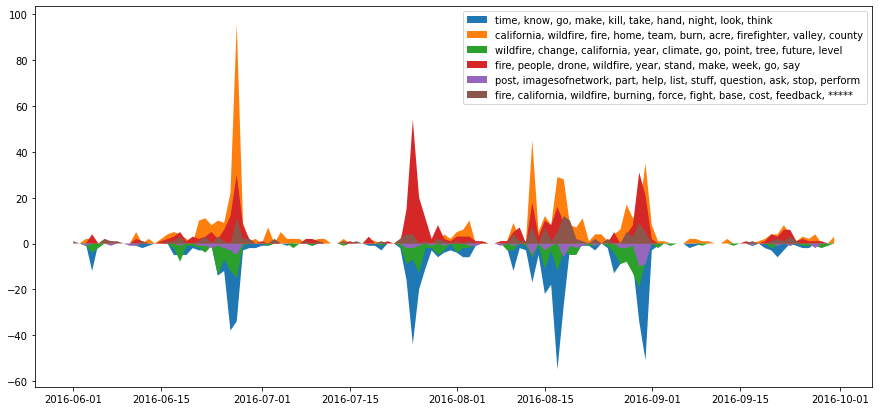

In [26]:
plt.figure(figsize=(15, 7))
for i in range(len(topics)):
    y = topic_time[topics[i]]
    x = topic_time.index
    if i%2==1:
        plt.stackplot(x,y) #,baseline='wiggle'
    else:
        plt.stackplot(x,-y) #,baseline='wiggle'
plt.legend(labels=topics)#,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0) 
plt.show()

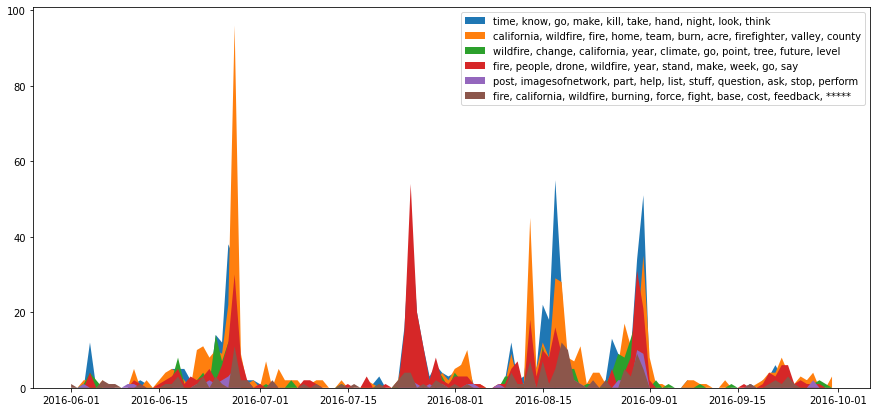

In [25]:
plt.figure(figsize=(15, 7))
for i in range(len(topics)):
    y = topic_time[topics[i]]
    x = topic_time.index
    plt.stackplot(x,y)# ,alpha = 0.7) #,baseline='wiggle'
plt.legend(labels=topics)#,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0) 
plt.show()